# Functions, imports

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import random
import pandas as pd
import random
import datetime, os
import io
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.initializers import glorot_normal,  he_normal
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Input, Dense, Lambda, LSTM, RepeatVector, Bidirectional, Masking, Dropout, Layer, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ConvLSTM3D, Conv1D, ConvLSTM2D, MaxPool1D, AvgPool1D, Conv2D, AvgPool2D, SimpleRNN
from google.colab import drive
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras
import os
from sklearn.decomposition import PCA
import time
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

from sklearn.mixture import GaussianMixture
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_predictions_ensemble1(predictions, x_test, y_test, model_name, clipRUL=True):
    n_predictors = len(predictions)
    preds = np.zeros(x_test.shape[0]).reshape(-1)
    for p in predictions:
        pred = p[0].mean(axis=1)
        preds += pred
    preds = preds/n_predictors

    sigmu = np.zeros(x_test.shape[0]).reshape(-1)
    for p in predictions:
      sigmas = p[1].mean(axis=1)
      mus = p[0].mean(axis=1)
      sigmu += (sigmas + mus**2)

    var = sigmu/n_predictors - preds**2
    std = np.sqrt(var)

    if clipRUL==True:
      y_test_c = y_test.copy()
      y_test_c['RemainingUsefulLife'].clip(upper=125, inplace=True)
      y_test_n = y_test.copy()
    else:
      y_test_c = y_test.copy()
    plt.plot(y_test_c, label='true RUL', c='#91c0cf', linewidth=3.0)
    plt.plot(preds, label='prediction', c = '#2e3d42', )

    plt.legend(loc="upper left")
    preds =  mus

    sum_sq = sum((preds.flatten() - y_test_c.values.flatten())**2)
    sum_sq1 = sum((preds.flatten() - y_test_n.values.flatten())**2)
    print(f"RMSE with clipped RUL is {(sum_sq/100)**(1/2)}")
    print(f"RMSE with clipped RUL is {(sum_sq1/100)**(1/2)}")
    plt.savefig(f'/content/drive/MyDrive/images/_{model_name}_unsorted.png')

    return preds, sigmu

import pickle


import pickle as pkl
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


def read_pickle_get_data(file_name, plot=True):
    history_base = []
    with open(f"/content/drive/MyDrive/pickled_history_new/{file_name}.pkl", 'rb') as openfile:
        while True:
            try:
                history_base.append(pkl.load(openfile))
            except EOFError:
                break

    losses = []
    val_losses = []
    mses = []
    val_mses = []
    settings = []
    for i, n in enumerate(history_base):
        loss = n[0].get('loss')
        val_loss = n[0].get('val_loss')
        mse = n[0].get('mse')
        val_mse = n[0].get('val_mse')
        losses.append(loss)
        val_losses.append(val_loss)
        mses.append(mse)
        val_mses.append(val_mse)
        settings.append(n[1])
    if plot:
        for m, mse in enumerate(val_mses):
            plt.plot(mse, c='#2e3d42', alpha = 0.9, label = 'val_mse')
            plt.plot(mses[m], c='#91c0cf', alpha=0.9, label='mse')
            if m == 0:
                plt.legend(loc="upper right")

        plt.title('Train and validation MSE')
        plt.savefig(f"/content/drive/MyDrive/images_new/{file_name}_mse.png")

        plt.show()

        for l, loss in enumerate(losses):
            plt.plot(loss, c='#91c0cf', label='loss')
            plt.plot(val_losses[l], c= '#2e3d42', label='val_loss')
            if l == 0:
                plt.legend(loc="upper right")
        plt.title('Train and validation Loss')
        plt.savefig(f"/content/drive/MyDrive/images_new/{file_name}_loss.png")
        plt.show()
    return losses, val_losses, mses, val_mses, settings


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_rul_one_engine(engine_number, functions_list):
    eng10 = gen_data_wrapper(X_test_pre, 30, sensors, unit_nrs=np.array([engine_number]))

    ruls = []
    for i in range(len(eng10), 0, -1):
      if i >= 125:
        ruls.append(125)
      else:
        ruls.append(i)

    mus = []
    sigmas = []
    n_predictors = len(functions_list)
    preds = np.zeros(eng10.shape[0]).reshape(-1)

    for p in functions_list:
      pred = p(eng10)[0].mean(axis=1)
      preds += pred.reshape(-1)
    preds = preds/n_predictors


    sigmu = np.zeros(eng10.shape[0]).reshape(-1)
    for p in functions_list:
      sigmas = p(eng10)[1].mean(axis=1)
      mus = p(eng10)[0].mean(axis=1)
      sigmu += (sigmas + mus**2)

    var = sigmu/n_predictors - preds**2
    std = np.sqrt(var)

    plt.plot(preds, label='prediction - mean')
    plt.plot((preds + std), label='prediction + 1std')
    plt.plot((preds - std), label='prediction - 1std')
    plt.legend(loc="lower left")

def get_predictions_ensemble(function_list, x_test, y_test, model_name,clipRUL):
    n_predictors = len(function_list)
    preds = np.zeros(x_test.shape[0]).reshape(-1)
    for p in function_list:
        pred = p(x_test)[0].mean(axis=1)
        preds += pred
    preds = preds/n_predictors

    sigmu = np.zeros(x_test.shape[0]).reshape(-1)
    for p in function_list:
      sigmas = p(x_test)[1].mean(axis=1)
      mus = p(x_test)[0].mean(axis=1)
      sigmu += (sigmas + mus**2)

    var = sigmu/n_predictors - preds**2
    std = np.sqrt(var)
    if clipRUL==True:
      y_test_c = y_test.copy()
      y_test_c['RUL'].clip(upper=125, inplace=True)
      y_test_n = y_test.copy()
    else:
      y_test_c = y_test.copy()
    plt.plot(y_test_c, label='true RUL', c='#91c0cf', linewidth=3.0)
    plt.plot(preds, label='prediction', c = '#2e3d42', )
    plt.legend(loc="upper left")
    preds =  mus

    sum_sq = sum((preds.flatten() - y_test_c.values.flatten())**2)
    sum_sq1 = sum((preds.flatten() - y_test_n.values.flatten())**2)
    print(f"RMSE with clipped RUL is {(sum_sq/100)**(1/2)}")
    print(f"RMSE with clipped RUL is {(sum_sq1/100)**(1/2)}")
    plt.savefig(f'/content/drive/MyDrive/images/_{model_name}_unsorted.png')

    return preds, sigmu

def get_predictions_ensemble1(predictions, x_test, y_test, model_name, clipRUL=True):
    n_predictors = len(predictions)
    preds = np.zeros(x_test.shape[0]).reshape(-1)
    for p in predictions:
        pred = p[0].mean(axis=1)
        preds += pred
    preds = preds/n_predictors

    sigmu = np.zeros(x_test.shape[0]).reshape(-1)
    for p in predictions:
      sigmas = p[1].mean(axis=1)
      mus = p[0].mean(axis=1)
      sigmu += (sigmas + mus**2)

    var = sigmu/n_predictors - preds**2
    std = np.sqrt(var)

    if clipRUL==True:
      y_test_c = y_test.copy()
      y_test_c['RUL'].clip(upper=125, inplace=True)
      y_test_n = y_test.copy()
    else:
      y_test_c = y_test.copy()
    plt.plot(y_test_c, label='true RUL', c='#91c0cf', linewidth=3.0)
    plt.plot(preds, label='prediction', c = '#2e3d42', )

    plt.legend(loc="upper left")
    preds =  mus

    sum_sq = sum((preds.flatten() - y_test_c.values.flatten())**2)
    sum_sq1 = sum((preds.flatten() - y_test_n.values.flatten())**2)
    print(f"RMSE with clipped RUL is {(sum_sq/100)**(1/2)}")
    print(f"RMSE with clipped RUL is {(sum_sq1/100)**(1/2)}")
    plt.savefig(f'/content/drive/MyDrive/images/_{model_name}_unsorted.png')

    return preds, sigmu




def plot_sorted(predictions, y_test, model_name, clipRUL=True):
    RUL_vals = y_test.RemainingUsefulLife.sort_values().values
    RUL_idx = y_test.RemainingUsefulLife.sort_values().index
    sorted_preds = []
    for n in RUL_idx:
      sorted_preds.append(predictions[n])

    if clipRUL:
      rul_vals = []
      for val in RUL_vals:
        if val>=125:
          rul_vals.append(125)
        else: rul_vals.append(val)

    else:
      rul_vals = RUL_vals

    plt.plot(rul_vals,  label='true RUL', c='#91c0cf', linewidth=3.0)
    plt.plot(sorted_preds, label='prediction',c = '#2e3d42',)
    plt.legend(loc="upper left")
    plt.savefig(f'/content/drive/MyDrive/images/_{model_name}.png')



def rul_col_series(df):
    max_cycles = df[['engine_no', 'cycles']].groupby('engine_no').max().values
    max_cycles = [n[0] for n in max_cycles]
    rul_column = []
    for c in max_cycles:
        c_rul = list(range(c, 0, -1))
        for r in c_rul:
            rul_column.append(r -1)
    df['RUL'] = rul_column

def add_operating_condition(df):
    df_op_cond = df.copy()

    df_op_cond['opc1'] = abs(df_op_cond['opc1'].round())
    df_op_cond['opc2'] = abs(df_op_cond['opc2'].round(decimals=2))

    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['opc1'].astype(str) + '_' + \
                        df_op_cond['opc2'].astype(str) + '_' + \
                        df_op_cond['opc3'].astype(str)
    return df_op_cond

def add_health_index(df):
    df_health_index = df.copy()
    df_health_index['health'] = 3
    df_health_index.loc[df_health_index['RUL'] <= 200, 'health'] = 2
    df_health_index.loc[df_health_index['RUL'] <= 125, 'health'] = 1
    df_health_index.loc[df_health_index['RUL'] <= 50, 'health'] = 0
    return df_health_index

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling

    for condition in df_train['op_cond'].unique():
        scaler = StandardScaler()
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test


def exponential_smoothing(df, sensors, n_samples, alpha=0.4):  #  df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('engine_no')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0, drop=True)

    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    mask = df.groupby('engine_no')['engine_no'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    return df

# alpha = 0.1
# # exponential smoothing
# X_train_pre= exponential_smoothing(X_train_pre, sensors, 0, alpha)
# X_test_pre = exponential_smoothing(X_test_pre, sensors, 0, alpha)


def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]



def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]



def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values

    # specifically yield the last possible sequence
    stop = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]



def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['engine_no'].unique()

    data_gen = (list(gen_train_data(df[df['engine_no']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['engine_no'].unique()

    label_gen = [gen_labels(df[df['engine_no']==unit_nr], sequence_length, label)
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array



def process_data_standard(dataset, sensors, data_folder, algo='regr', clust=0, include_settings=False):
    train_file = 'train_'+dataset+'.txt'
    test_file = 'test_'+dataset+'.txt'
    # columns
    index_names = ["engine_no", "cycles"]
    setting_names = ["opc1", "opc2", "opc3"]

    col_names = index_names + setting_names + sensor_names

    train = pd.read_csv((data_folder+train_file), sep=r'\s+', header=None,
              names=col_names)
    test = pd.read_csv((data_folder+test_file), sep=r'\s+', header=None,
              names=col_names)
    y_test = pd.read_csv((data_folder+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None,
              names=['RUL'])


    # create RUL values according to the piece-wise target function
    rul_col_series(train)
    if algo == 'regr':
        train['RUL'].clip(upper=125, inplace=True)
    train = add_health_index(train)

    if include_settings:
      sensors = sensors + setting_names
    # remove unused sensors
    drop_sensors = [element for element in sensor_names if element not in sensors]

    # scale with respect to the operating condition
    X_train_pre = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_pre = add_operating_condition(test.drop(drop_sensors, axis=1))



    X_train_pre, X_test_pre = condition_scaler(X_train_pre, X_test_pre, sensors)



    # if dataset in ('FD002', 'FD004'):
    #     x_gmm = X_train_pre.copy()
    #     gmm = GaussianMixture(n_components = 5)

    #     # Fit the GMM model for the dataset
    #     # which expresses the dataset as a
    #     # mixture of 3 Gaussian Distribution
    #     gmm.fit(x_gmm[sensors])
    #     X_train_pre['cluster'] = gmm.predict(x_gmm[sensors])
    #     X_train_pre_clust1 = X_train_pre.loc[X_train_pre.cluster==1]
    #     X_train_pre_clust0 = X_train_pre.loc[X_train_pre.cluster==0]

    #     if clust == 0:
    #       X_train_pre = X_train_pre_clust0
    #     else: X_train_pre = X_train_pre_clust1



    sequence_length = 30


    # train-val split
    gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
    # generate the train/val for *each* sample -> for that we iterate over the train and val units we want
    # this is a for that iterates only once and in that iterations at the same time iterates over all the values we want,
    # i.e. train_unit and val_unit are not a single value but a set of training/vali units

    for train_unit, val_unit in gss.split(X_train_pre['engine_no'].unique(), groups=X_train_pre['engine_no'].unique()):
        train_unit = X_train_pre['engine_no'].unique()[train_unit]  # gss returns indexes and index starts at 1
        val_unit = X_train_pre['engine_no'].unique()[val_unit]


        x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
        y_train = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)

        if algo != 'regr':
            y_train = gen_label_wrapper(X_train_pre, sequence_length, ['health'], train_unit)


        x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
        y_val = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)


        if algo != 'regr':
            y_val = gen_label_wrapper(X_train_pre, sequence_length, ['health'], val_unit)

    # create sequences for test
    test_gen = (list(gen_test_data(X_test_pre[X_test_pre['engine_no']==unit_nr], sequence_length, sensors, -99.))
            for unit_nr in X_test_pre['engine_no'].unique())
    x_test = np.concatenate(list(test_gen)).astype(np.float32)

    return x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre



def process_data_standard2(dataset, sensors, data_folder, condition, sequence_length = 30, algo='regr', clust=-1, get_by_cond=False,  include_settings=False):
    train_file = 'train_'+dataset+'.txt'
    test_file = 'test_'+dataset+'.txt'
    # columns
    index_names = ["engine_no", "cycles"]
    setting_names = ["opc1", "opc2", "opc3"]

    col_names = index_names + setting_names + sensor_names

    train = pd.read_csv((data_folder+train_file), sep=r'\s+', header=None,
              names=col_names)
    test = pd.read_csv((data_folder+test_file), sep=r'\s+', header=None,
              names=col_names)
    y_test = pd.read_csv((data_folder+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None,
              names=['RUL'])


    # create RUL values according to the piece-wise target function
    rul_col_series(train)
    if algo == 'regr':
        train['RUL'].clip(upper=125, inplace=True)
    train = add_health_index(train)

    # if include_settings is True, then includes the operating conditions
    if include_settings:
      sensors = sensors + setting_names
    # remove unused sensors
    drop_sensors = [element for element in sensor_names if element not in sensors]

    # scale with respect to the operating condition
    X_train_pre = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_pre = add_operating_condition(test.drop(drop_sensors, axis=1))



    X_train_pre, X_test_pre = condition_scaler(X_train_pre, X_test_pre, sensors)


    # If clust is 0 or 1, performs GMM clustering and returns the requested cluster to continue processing
    if clust in [0,1]:
        sequence_length = sequence_length
        x_gmm = X_train_pre.copy()
        gmm = GaussianMixture(n_components = 2)

        # Fit the GMM model for the dataset
        # which expresses the dataset as a
        # mixture of 3 Gaussian Distribution
        gmm.fit(x_gmm[sensors])
        X_train_pre['cluster'] = gmm.predict(x_gmm[sensors])
        X_train_pre_clust1 = X_train_pre.loc[X_train_pre.cluster==1]
        X_train_pre_clust0 = X_train_pre.loc[X_train_pre.cluster==0]

        if clust == 0:
          X_train_pre = X_train_pre_clust0
        else: X_train_pre = X_train_pre_clust1

    # if get_by_cond is True, returns a processed subset of the requested operating condition
    if get_by_cond:
        X_train_pre = X_train_pre.loc[X_train_pre.op_cond ==condition].reindex()




    # train-val split
    gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
    # generate the train/val for *each* sample -> for that we iterate over the train and val units we want
    # this is a for that iterates only once and in that iterations at the same time iterates over all the values we want,
    # i.e. train_unit and val_unit are not a single value but a set of training/vali units

    for train_unit, val_unit in gss.split(X_train_pre['engine_no'].unique(), groups=X_train_pre['engine_no'].unique()):

        train_unit = X_train_pre['engine_no'].unique()[train_unit]  # gss returns indexes and index starts at 1
        val_unit = X_train_pre['engine_no'].unique()[val_unit]

        x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
        y_train = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)
        # makes health indiex if the process is for algorithms other than regression
        if algo != 'regr':
            y_train = gen_label_wrapper(X_train_pre, sequence_length, ['health'], train_unit)


        x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
        y_val = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)

        # makes health indiex if the process is for algorithms other than regression
        if algo != 'regr':
            y_val = gen_label_wrapper(X_train_pre, sequence_length, ['health'], val_unit)

    # create sequences for test

    test_gen = (list(gen_test_data(X_test_pre[X_test_pre['engine_no']==unit_nr],
                                   sequence_length, sensors, -99.))
            for unit_nr in X_test_pre['engine_no'].unique())
    x_test = np.concatenate(list(test_gen)).astype(np.float32)

    return x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre


# Plot encoder

### Read saved files

In [ ]:
with  open('/content/drive/MyDrive/pickled_history_new/history_encoder_base.pkl', 'rb') as f:
  encoder_base = pickle.load(f)
with  open('/content/drive/MyDrive/pickled_history_new/history_encoder_var1.pkl', 'rb') as f:
  encoder1 = pickle.load(f)
with  open('/content/drive/MyDrive/pickled_history_new/history_encoder_var2.pkl', 'rb') as f:
  encoder2 = pickle.load(f)
with  open('/content/drive/MyDrive/pickled_history_new/history_encoder_var3.pkl', 'rb') as f:
  encoder3 = pickle.load(f)

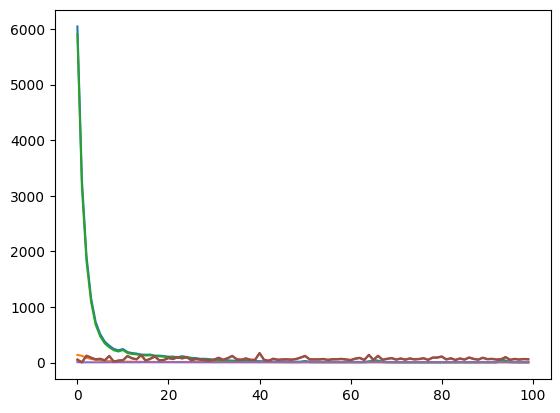

In [ ]:
losses = ['loss', 'kl_loss', 'reg_loss', 'val_loss', 'val_kl_loss', 'val_reg_loss']
for loss in losses:
  plt.plot(encoder_base[0][loss])


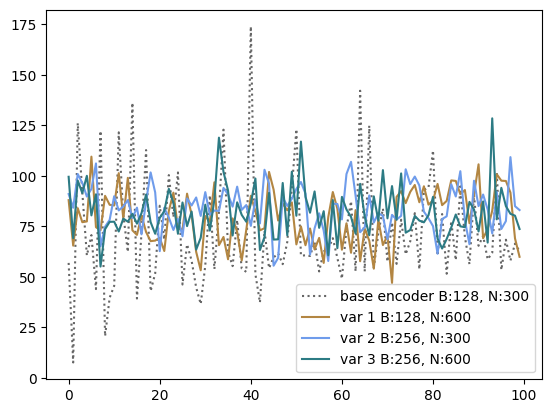

In [ ]:
losses = ['val_loss']
for loss in losses:

  plt.plot(encoder_base[0][loss], ':', label='base encoder B:128, N:300', c='black', alpha=0.6)
  plt.plot(encoder1[0][loss], label='var 1 B:128, N:600', c='#b38642')
  plt.plot(encoder2[0][loss],label='var 2 B:256, N:300', c='#6f9ceb')
  plt.plot(encoder3[0][loss],label='var 3 B:256, N:600', c='#2c7b84')
  plt.legend(loc="lower right")
  plt.show()


In [ ]:
with  open('/content/drive/MyDrive/pickled_predictions_new/preds_encoder_base.pkl', 'rb') as f:
  epredictions_base = pickle.load(f)
with  open('/content/drive/MyDrive/pickled_predictions_new/preds_encoder_var1.pkl', 'rb') as f:
  epreds1 = pickle.load(f)
with  open('/content/drive/MyDrive/pickled_predictions_new/preds_encoder_var2.pkl', 'rb') as f:
  epreds2 = pickle.load(f)

# Plot ensemble

In [ ]:
predictions = {}
settings = {}
list_hist = os.listdir('/content/drive/MyDrive/pickled_history_new')


<ipython-input-10-802c965384bb>:45: RuntimeWarning: invalid value encountered in divide
  plt.plot(mse_results/loss_res_counts, c=color, linestyle='dashed', linewidth=lines)
<ipython-input-10-802c965384bb>:46: RuntimeWarning: invalid value encountered in divide
  plt.plot(val_mse_results/loss_res_counts, label=labels, c= color, linewidth=lines)


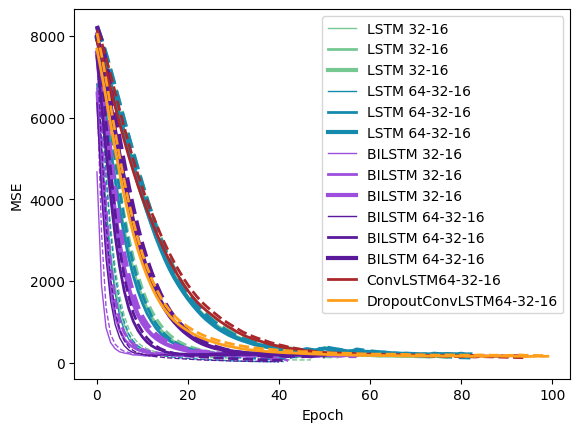

In [ ]:
models = ['LSTM_base_history.pkl', 'LSTM_var1_history.pkl', 'LSTM_var2_history.pkl',
          'LSTM_var3_history.pkl','LSTM_var4_history.pkl', 'LSTM_var5_history.pkl',
          'LSTM_var6BI_history.pkl', 'LSTM_var7BI_history.pkl', 'LSTM_var8BI_history.pkl',
          'LSTM_var9BI_history.pkl', 'LSTM_var10BI_history.pkl', 'LSTM_var11BI_history.pkl',
          'LSTM_var12Conv_history.pkl', 'LSTM_var12ConvDropout_history.pkl',]


colors = ['#76c893','#76c893','#76c893',
          '#168aad','#168aad','#168aad',
          '#9d4edd','#9d4edd', '#9d4edd',
          '#5a189a','#5a189a', '#5a189a',
          '#aa282b',
          '#ff9f1c',
          ]

labels = ['LSTM 32-16', 'LSTM 32-16', 'LSTM 32-16', 'LSTM 64-32-16','LSTM 64-32-16','LSTM 64-32-16',
          'BILSTM 32-16', 'BILSTM 32-16', 'BILSTM 32-16', 'BILSTM 64-32-16','BILSTM 64-32-16','BILSTM 64-32-16',
          'ConvLSTM64-32-16', 'DropoutConvLSTM64-32-16'
          ]

line_width = [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 2, 2]


for model, color, lines, labels  in zip(models, colors, line_width, labels):
      losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data(model.replace('.pkl', ''), plot=False)


      loss_res = np.zeros(100)
      val_loss_res = np.zeros(100)
      mse_results = np.zeros(100)
      val_mse_results = np.zeros(100)

      loss_res_counts = np.zeros(100)


      for n0, loss in enumerate(losses):
        for n, e in enumerate(loss):
          loss_res[n] += e
          val_loss_res[n] += np.array(val_losses[n0][n],dtype=object)
          mse_results[n] += np.array(mses[n0][n])
          val_mse_results[n] += np.array(val_mses[n0][n])
          loss_res_counts[n] += 1


      plt.plot(mse_results/loss_res_counts, c=color, linestyle='dashed', linewidth=lines)
      plt.plot(val_mse_results/loss_res_counts, label=labels, c= color, linewidth=lines)
      plt.xlabel("Epoch")
      plt.ylabel("MSE")
      if lines == 2:
        plt.legend(loc="upper right")





### Other plots - ensemble mse at training and validation, one line for  each model

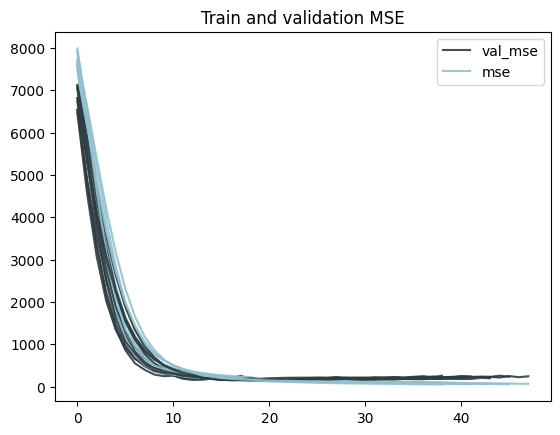

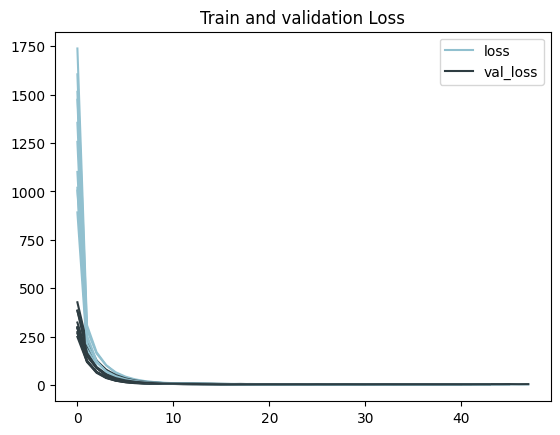

In [ ]:
losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data('LSTM_base_history')


<ipython-input-254-abd0c70b896c>:24: RuntimeWarning: invalid value encountered in divide
  plt.plot(loss_res/loss_res_counts, c='#91c0cf', label='loss')
<ipython-input-254-abd0c70b896c>:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(val_loss_res/loss_res_counts, c= '#2e3d42', label='val_loss')


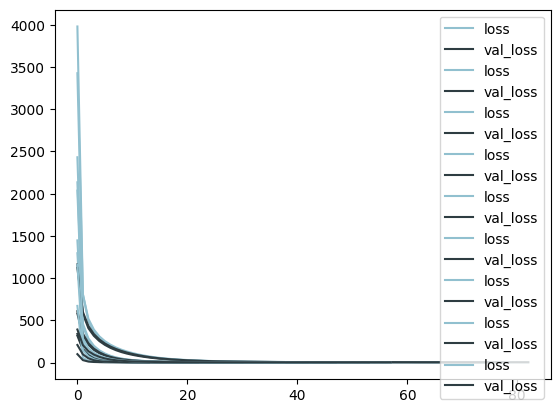

In [ ]:
models = ['LSTM_base_history.pkl','LSTM_var1_history.pkl', 'LSTM_var2_history.pkl', 'LSTM_var3_history.pkl',
          'LSTM_var4_history.pkl', 'LSTM_var5_history.pkl', 'LSTM_var6BI_history.pkl', 'LSTM_var7BI_history.pkl',
          'LSTM_var8BI_history.pkl']

for model in models:
      losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data(model.replace('.pkl', ''), plot=False)


      loss_res = np.zeros(100)
      val_loss_res = np.zeros(100)
      mse_results = np.zeros(100)
      val_mse_results = np.zeros(100)

      loss_res_counts = np.zeros(100)


      for n0, loss in enumerate(losses):
        for n, e in enumerate(loss):
          loss_res[n] += e
          val_loss_res[n] += np.array(val_losses[n0][n],dtype=object)
          mse_results[n] += np.array(mses[n0][n])
          val_mse_results[n] += np.array(val_mses[n0][n])
          loss_res_counts[n] += 1
      plt.plot(loss_res/loss_res_counts, c='#91c0cf', label='loss')
      plt.plot(val_loss_res/loss_res_counts, c= '#2e3d42', label='val_loss')
      plt.legend(loc="upper right")






In [ ]:
len(np.array(losses))

<ipython-input-227-b7d475ec327f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  len(np.array(losses))


9

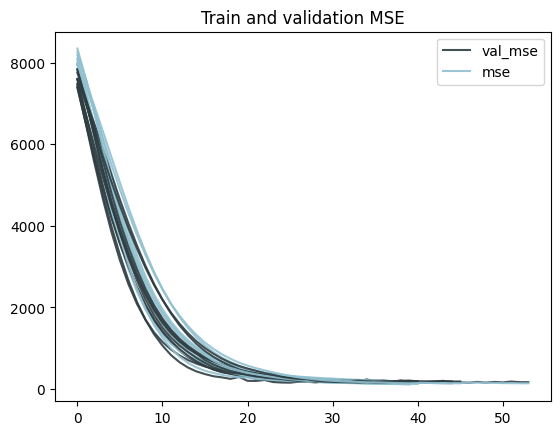

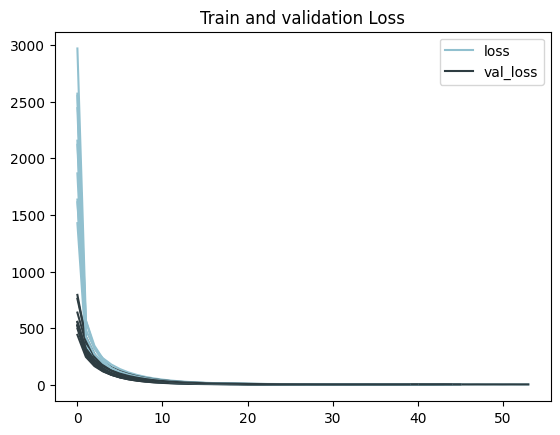

In [ ]:
losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data('LSTM_var1_history')


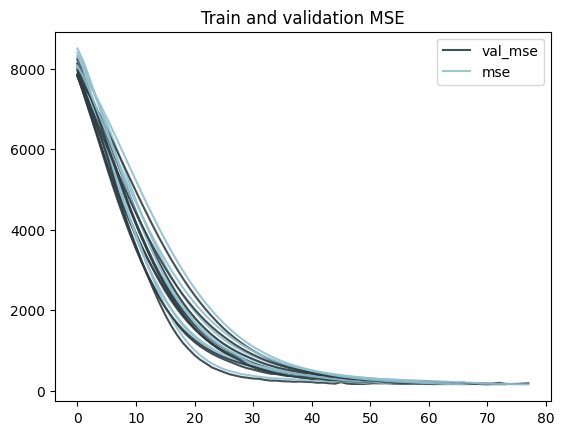

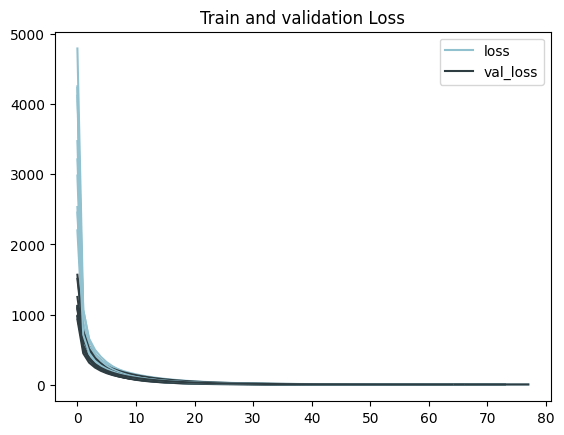

In [ ]:
losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data('LSTM_var2_history')


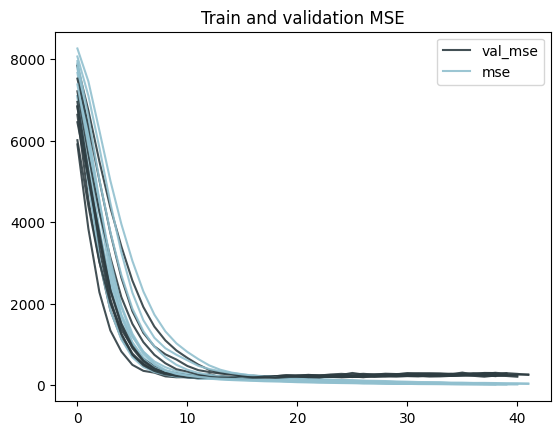

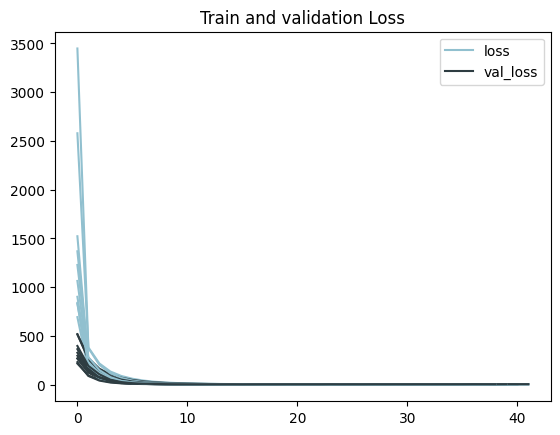

In [ ]:
losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data('LSTM_var3_history')


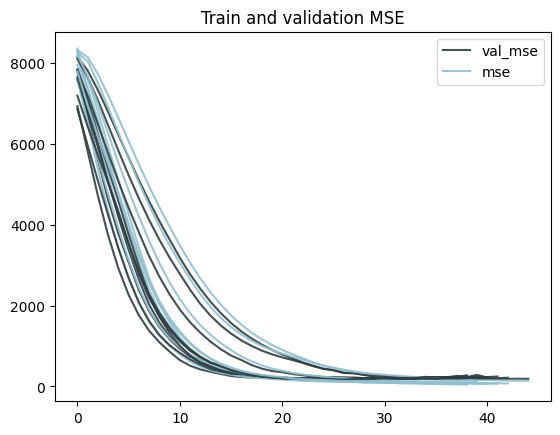

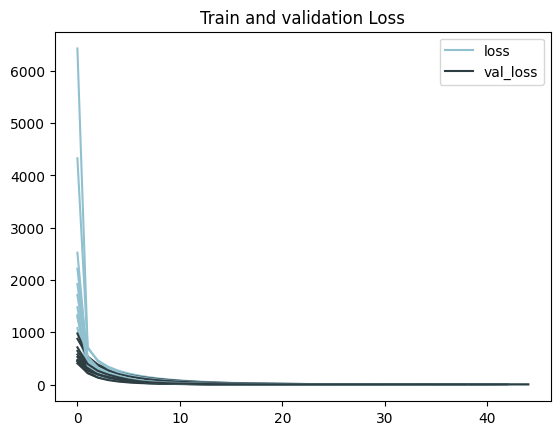

In [ ]:
losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data('LSTM_var4_history')


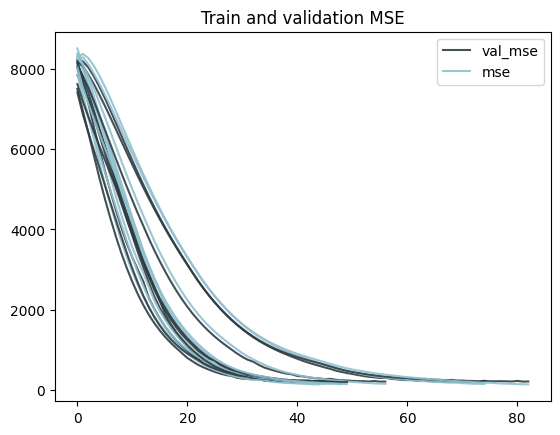

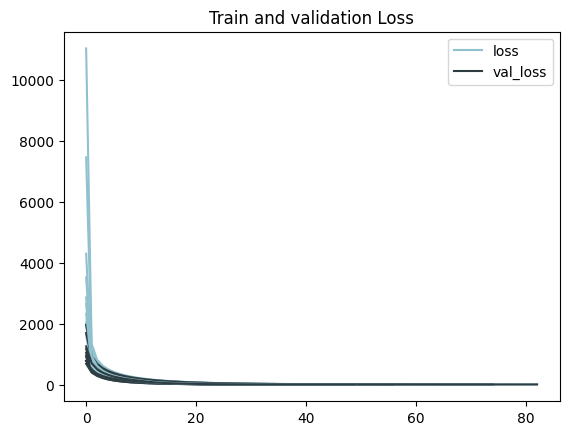

In [ ]:
losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data('LSTM_var5_history')


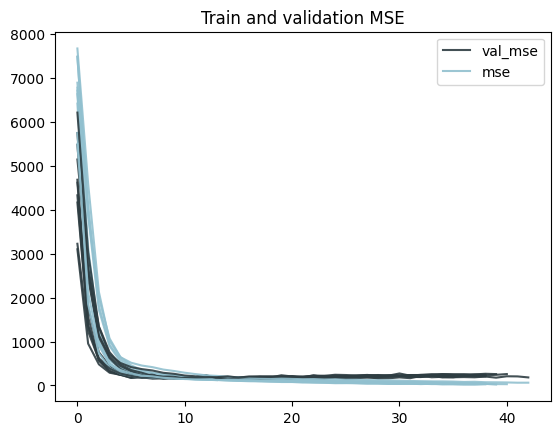

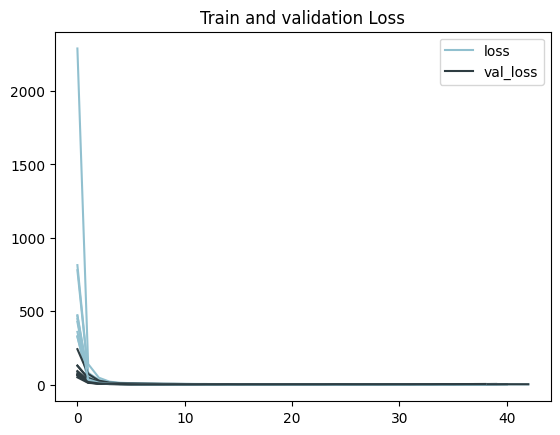

In [ ]:
losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data('LSTM_var6BI_history')


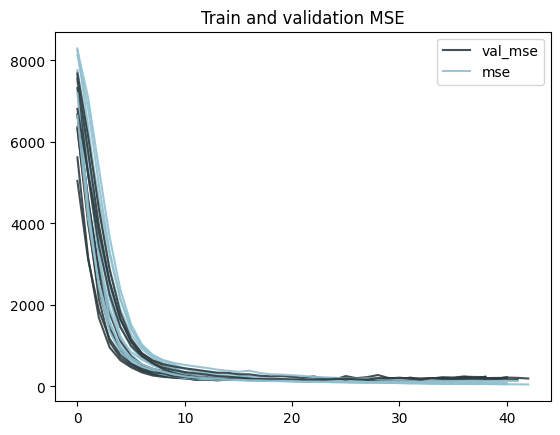

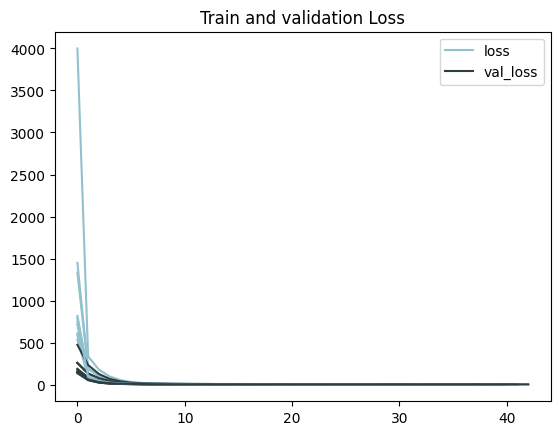

In [ ]:
losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data('LSTM_var7BI_history')


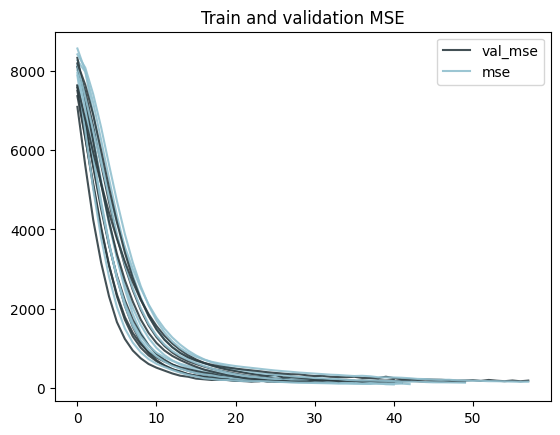

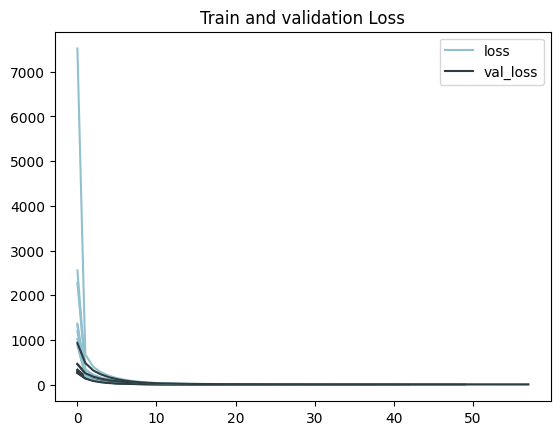

In [ ]:
losses, val_losses, mses, val_mses, settings0 = read_pickle_get_data('LSTM_var8BI_history')


# Classification

## All results classification

### Read pickled metrics and predicitons

In [ ]:
with open('/content/drive/MyDrive/classiff_results/stacking_preds.pkl', 'rb') as f:
  stack_test, stack_pred = pickle.load(f)


In [ ]:
with open('/content/drive/MyDrive/classiff_results/history30l1-4.pkl', 'rb') as f:
  h1, h2, h3, h4 = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/classiff_results/history1l.pkl', 'rb') as f:
  h1l, h2l, h3l, h4l = pickle.load(f)

## Elman training and validation plots

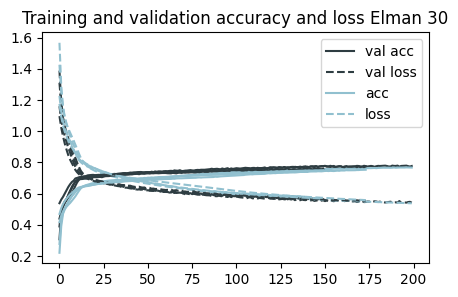

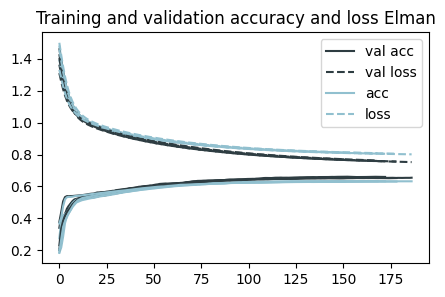

In [ ]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(figsize=(5,3))

for n, h in enumerate(h1):
  plt.plot(h['val_acc'], c='#2e3d42', label='val acc')
  plt.plot(h['val_loss'], '--', c='#2e3d42', label='val loss')
  plt.plot(h['acc'], c='#91c0cf', label='acc')
  plt.plot(h['loss'], '--', c='#91c0cf', label = 'loss')
  if n== 0:
      plt.legend(loc="upper right")
ax.set_title('Training and validation - Elman 30 - FD001')
plt.show()

fig, ax  = plt.subplots(figsize=(5,3))
for n, h in enumerate(h1l):
  plt.plot(h['val_acc'], c='#2e3d42', label='val acc')
  plt.plot(h['val_loss'], '--', c='#2e3d42', label='val loss')
  plt.plot(h['acc'], c='#91c0cf', label='acc')
  plt.plot(h['loss'], '--', c='#91c0cf', label = 'loss')
  if n== 0:
      plt.legend(loc="upper right")
ax.set_title('Training and validation - Elman - FD001')

plt.show()




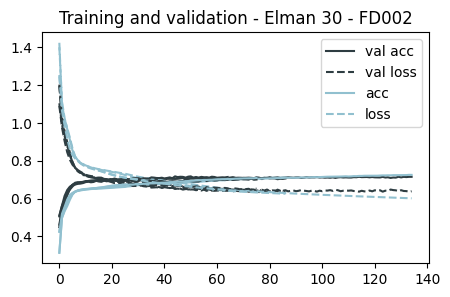

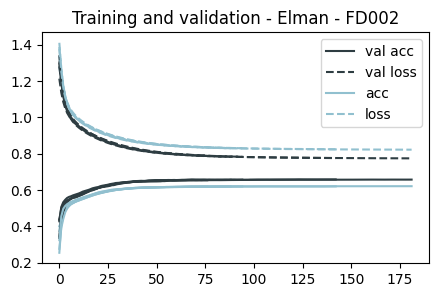

In [ ]:
fig, ax  = plt.subplots(figsize=(5,3))

for n, h in enumerate(h2):
  plt.plot(h['val_acc'], c='#2e3d42', label='val acc')
  plt.plot(h['val_loss'], '--', c='#2e3d42', label='val loss')
  plt.plot(h['acc'], c='#91c0cf', label='acc')
  plt.plot(h['loss'], '--', c='#91c0cf', label = 'loss')
  if n== 0:
      plt.legend(loc="upper right")
ax.set_title('Training and validation - Elman 30 - FD002')
plt.show()

fig, ax  = plt.subplots(figsize=(5,3))
for n, h in enumerate(h2l):
  plt.plot(h['val_acc'], c='#2e3d42', label='val acc')
  plt.plot(h['val_loss'], '--', c='#2e3d42', label='val loss')
  plt.plot(h['acc'], c='#91c0cf', label='acc')
  plt.plot(h['loss'], '--', c='#91c0cf', label = 'loss')
  if n== 0:
      plt.legend(loc="upper right")
ax.set_title('Training and validation - Elman - FD002')

plt.show()

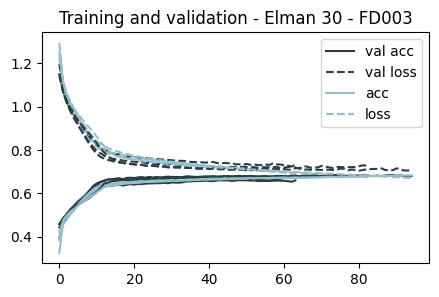

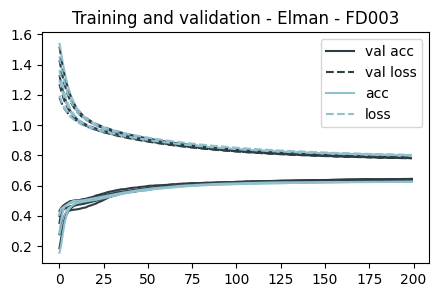

In [ ]:
fig, ax  = plt.subplots(figsize=(5,3))

for n, h in enumerate(h3):
  plt.plot(h['val_acc'], c='#2e3d42', label='val acc')
  plt.plot(h['val_loss'], '--', c='#2e3d42', label='val loss')
  plt.plot(h['acc'], c='#91c0cf', label='acc')
  plt.plot(h['loss'], '--', c='#91c0cf', label = 'loss')
  if n== 0:
      plt.legend(loc="upper right")
ax.set_title('Training and validation - Elman 30 - FD003')
plt.show()

fig, ax  = plt.subplots(figsize=(5,3))
for n, h in enumerate(h3l):
  plt.plot(h['val_acc'], c='#2e3d42', label='val acc')
  plt.plot(h['val_loss'], '--', c='#2e3d42', label='val loss')
  plt.plot(h['acc'], c='#91c0cf', label='acc')
  plt.plot(h['loss'], '--', c='#91c0cf', label = 'loss')
  if n== 0:
      plt.legend(loc="upper right")
ax.set_title('Training and validation - Elman - FD003')

plt.show()

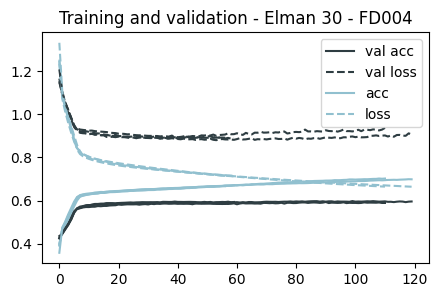

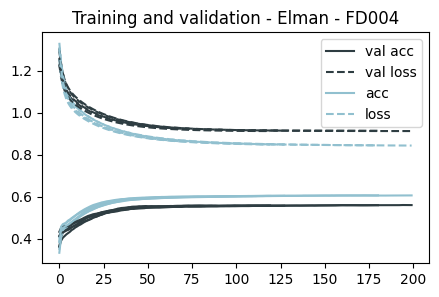

In [ ]:
fig, ax  = plt.subplots(figsize=(5,3))

for n, h in enumerate(h4):
  plt.plot(h['val_acc'], c='#2e3d42', label='val acc')
  plt.plot(h['val_loss'], '--', c='#2e3d42', label='val loss')
  plt.plot(h['acc'], c='#91c0cf', label='acc')
  plt.plot(h['loss'], '--', c='#91c0cf', label = 'loss')
  if n== 0:
      plt.legend(loc="upper right")
ax.set_title('Training and validation - Elman 30 - FD004')
plt.show()

fig, ax  = plt.subplots(figsize=(5,3))
for n, h in enumerate(h4l):
  plt.plot(h['val_acc'], c='#2e3d42', label='val acc')
  plt.plot(h['val_loss'], '--', c='#2e3d42', label='val loss')
  plt.plot(h['acc'], c='#91c0cf', label='acc')
  plt.plot(h['loss'], '--', c='#91c0cf', label = 'loss')
  if n== 0:
      plt.legend(loc="upper right")
ax.set_title('Training and validation - Elman - FD004')

plt.show()

## Elman predictions from all models


In [ ]:
dataset = 'FD002'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]



sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']


# whole dataset 1
x_train1, y_train1, x_val1, y_val1, x_test1, y_test1, X_train_pre1, X_test_pre1 = process_data_standard2('FD001',
                                                                                                 sensors,
                                                                                                 dir_path,
                                                                                                 condition ='10.0_0.25_100.0',
                                                                                                 algo='clf',
                                                                                                 clust=-1)


# whole dataset 2
x_train2, y_train2, x_val2, y_val2, x_test2, y_test2, X_train_pre2, X_test_pre2 = process_data_standard2('FD002',
                                                                                                 sensors,
                                                                                                 dir_path,
                                                                                                 condition ='10.0_0.25_100.0',
                                                                                                 algo='clf',
                                                                                                 clust=-1)

# whole dataset 3
x_train3, y_train3, x_val3, y_val3, x_test3, y_test3, X_train_pre3, X_test_pre3 = process_data_standard2('FD003',
                                                                                                 sensors,
                                                                                                 dir_path,
                                                                                                 condition ='10.0_0.25_100.0',
                                                                                                 algo='clf',
                                                                                                 clust=-1)


# whole dataset 4
x_train4, y_train4, x_val4, y_val4, x_test4, y_test4, X_train_pre4, X_test_pre4 = process_data_standard2('FD004',
                                                                                                 sensors,
                                                                                                 dir_path,
                                                                                                 condition ='10.0_0.25_100.0',
                                                                                                 algo='clf',
                                                                                                 clust=-1)



x_train1l, y_train1l, x_val1l, y_val1l, x_test1l, y_test1l, X_train_pre1l, X_test_pre1l = process_data_standard2('FD001',
                                                                                                 sensors,
                                                                                                 dir_path,
                                                                                                 condition ='10.0_0.25_100.0',
                                                                                                 algo='clf', sequence_length=1,

                                                                                                 clust=-1)

x_train2l, y_train2l, x_val2l, y_val2l, x_test2l, y_test2l, X_train_pre2l, X_test_pre2l = process_data_standard2('FD002',
                                                                                                 sensors,
                                                                                                 dir_path,
                                                                                                 condition ='10.0_0.25_100.0',
                                                                                                 algo='clf', sequence_length=1,

                                                                                                 clust=-1)

x_train3l, y_train3l, x_val3l, y_val3l, x_test3l, y_test3l, X_train_pre3l, X_test_pre3l = process_data_standard2('FD003',
                                                                                                 sensors,
                                                                                                 dir_path,
                                                                                                 condition ='10.0_0.25_100.0',
                                                                                                 algo='clf', sequence_length=1,

                                                                                                 clust=-1)

x_train4l, y_train4l, x_val4l, y_val4l, x_test4l, y_test4l, X_train_pre4l, X_test_pre4l = process_data_standard2('FD004',
                                                                                                 sensors,
                                                                                                 dir_path,
                                                                                                 condition ='10.0_0.25_100.0',
                                                                                                 algo='clf', sequence_length=1,

                                                                                                 clust=-1)


y_test1 = add_health_index(y_test1).health.values
y_test2 = add_health_index(y_test2).health.values
y_test3 = add_health_index(y_test3).health.values
y_test4 = add_health_index(y_test4).health.values

y_test1l = add_health_index(y_test1l).health.values
y_test2l = add_health_index(y_test2l).health.values
y_test3l = add_health_index(y_test3l).health.values
y_test4l = add_health_index(y_test4l).health.values


In [ ]:

e1l1 = ['elman1_ds1', 'elman1_v2_ds1', 'elman1_v3_ds1', 'elman1_v4_ds1', 'elman1_v5_ds1']
e1l2 = ['elman1_ds2', 'elman2_v2_ds2', 'elman2_v3_ds2', 'elman2_v4_ds2', 'elman2_v5_ds2']
e1l3 = ['elman1_ds3', 'elman3_v2_ds3', 'elman3_v3_ds3', 'elman3_v4_ds3', 'elman3_v5_ds3']
e1l4 = ['elman1_ds4', 'elman4_v2_ds4', 'elman4_v3_ds4', 'elman4_v4_ds4', 'elman4_v5_ds4']



In [ ]:



e30l1 = ['elman30_ds1', 'elman30_ds1v2', 'elman30_ds1v3', 'elman30_ds1v4', 'elman30_ds1v5']
e30l2 = ['elman30_ds2', 'elman30_ds2v2', 'elman30_ds2v3', 'elman30_ds2v4', 'elman30_ds2v5']
e30l3 = ['elman30_ds3', 'elman30_ds3v2', 'elman30_ds3v3', 'elman30_ds3v4', 'elman30_ds3v5']
e30l4 = ['elman30_ds4', 'elman30_ds4v2', 'elman30_ds4v3', 'elman30_ds4v4', 'elman30_ds4v5']
inputs = Input(shape=(1, len(sensors)))
x = SimpleRNN(256)(inputs)
x = Dense(4, activation='softmax')(x)

predictions = []
for m in e1l1:
    model = Model(inputs, x)
    model.load_weights(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    #print(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    predictions.append(model.predict(x_val1l))

In [ ]:
predictions1lds2 = []
for m in e1l2:
    model = Model(inputs, x)
    model.load_weights(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    #print(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    predictions1lds2.append(model.predict(x_val2l))

In [ ]:
predictions1lds3 = []
for m in e1l3:
    model = Model(inputs, x)
    model.load_weights(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    #print(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    predictions1lds3.append(model.predict(x_val3l))

In [ ]:
predictions1lds4 = []
for m in e1l4:
    model = Model(inputs, x)
    model.load_weights(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    #print(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    predictions1lds4.append(model.predict(x_val4l))

In [ ]:

e30l1 = ['elman30_ds1', 'elman30_ds1v2', 'elman30_ds1v3', 'elman30_ds1v4', 'elman30_ds1v5']
e30l2 = ['elman30_ds2', 'elman30_ds2v2', 'elman30_ds2v3', 'elman30_ds2v4', 'elman30_ds2v5']
e30l3 = ['elman30_ds3', 'elman30_ds3v2', 'elman30_ds3v3', 'elman30_ds3v4', 'elman30_ds3v5']
e30l4 = ['elman30_ds4', 'elman30_ds4v2', 'elman30_ds4v3', 'elman30_ds4v4', 'elman30_ds4v5']
inputs = Input(shape=(30, len(sensors)))
x = SimpleRNN(256)(inputs)
x = Dense(4, activation='softmax')(x)


In [ ]:
predictions30lds1 = []
for m in e30l1:
    model = Model(inputs, x)
    model.load_weights(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    #print(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    predictions30lds1.append(model.predict(x_val1))

In [ ]:
predictions30lds2 = []
for m in e30l2:
    model = Model(inputs, x)
    model.load_weights(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    #print(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    predictions30lds2.append(model.predict(x_val2))

In [ ]:
predictions30lds3 = []
for m in e30l3:
    model = Model(inputs, x)
    model.load_weights(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    #print(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    predictions30lds3.append(model.predict(x_val3))

In [ ]:
predictions30lds4 = []
for m in e30l4:
    model = Model(inputs, x)
    model.load_weights(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    #print(f"/content/drive/MyDrive/classiff_results/elman_models/{m}.ckpt")
    predictions30lds4.append(model.predict(x_val4))

### Mean accuracy for Elman and Elman30, for each dataset

In [ ]:
prediction_list = [predictions, predictions1lds2, predictions1lds3, predictions1lds4, predictions30lds1, predictions30lds2, predictions30lds3, predictions30lds4]

In [ ]:
from sklearn.metrics import accuracy_score
names = ['e1l', 'e2l', 'e3l', 'e4l', 'e301', 'e302', 'e303', 'e304']
ys = [y_val1l, y_val2l, y_val3l, y_val4l, y_val1, y_val2, y_val3, y_val4]
for pred, y, name in zip(prediction_list,ys, names):
  ds_preds = []
  for p in pred:
    ds_preds.append(accuracy_score(y, p.argmax(axis=1)))
  print(name, np.mean(ds_preds))


e1l 0.6555773955773956
e2l 0.6574647887323943
e3l 0.6421835174171622
e4l 0.5579590129652865
e301 0.7686532951289399
e302 0.7163764652327302
e303 0.6730135658914729
e304 0.596592099000476


## All models confusion matrix

In [ ]:
import pickle
import sklearn.metrics
with  open('/content/drive/MyDrive/classiff_results/all_classifiers_t.pkl', 'rb') as f:
  ds1_t, ds2_t, ds3_t, ds4_t = pickle.load(f)

In [ ]:
[[rft1, svmt1, lda1t, y_val1l,y_val1 ],[rfp1, svmp1, lda1p, y_pred1l, y_pred]] = ds1_t
[[rft2, svmt2, lda2t, y_val2l, y_val2],[rfp2, svmp2, lda2p, y_pred2l, y_pred2]] = ds2_t
[[rft3, svmt3, lda3t, y_val3l, y_val3],[rfp3, svmp3, lda3p, y_pred3l, y_pred3]] = ds3_t
[[rft4, svmt4, lda4t, y_val4l, y_val4],[rfp4, svmp4, lda4p, y_pred4l, y_pred4]] = ds4_t




In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(rft1, rfp1)

0.73

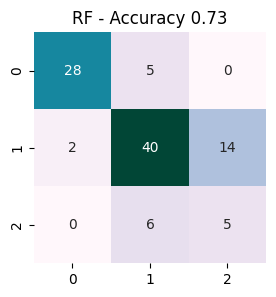

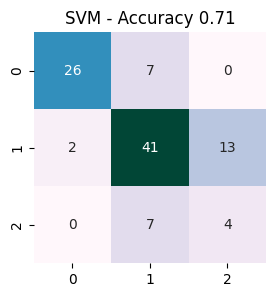

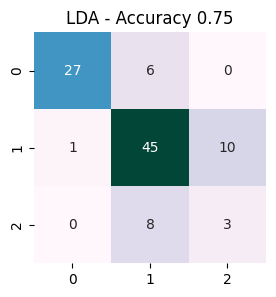

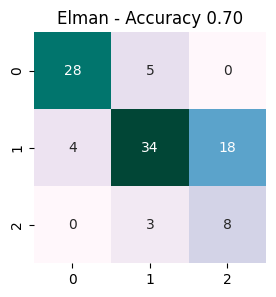

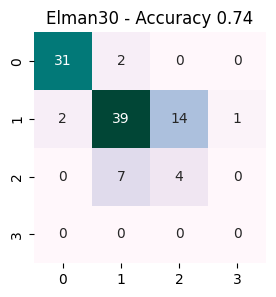

In [ ]:
models = ['RF', 'SVM', 'LDA', 'Elman', 'Elman30']
for t, p, m in zip(ds1_t[0], ds1_t[1], models):
  cm = confusion_matrix(t,p)
  fig, ax  = plt.subplots(figsize=(3,3))
  sns.heatmap(cm, annot=True, cbar=False, cmap='PuBuGn')
  acc = accuracy_score(t,p)
  ax.set_title(f'{m} - Accuracy {acc:.2f}')

  plt.savefig(f'/content/drive/MyDrive/images/{m}_ds1.png')
  plt.show()




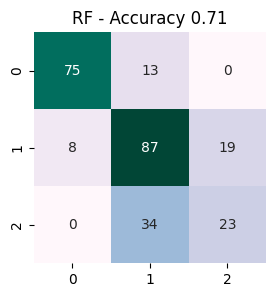

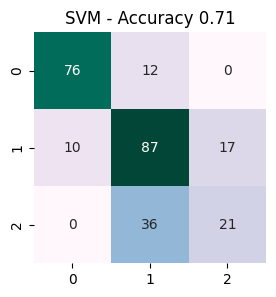

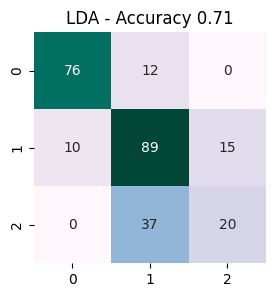

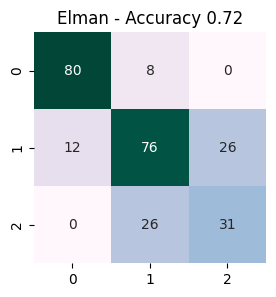

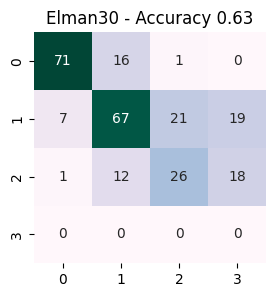

In [ ]:
models = ['RF', 'SVM', 'LDA', 'Elman', 'Elman30']
for t, p, m in zip(ds2_t[0], ds2_t[1], models):
  cm = confusion_matrix(t,p)
  fig, ax  = plt.subplots(figsize=(3,3))
  sns.heatmap(cm, annot=True, cbar=False, cmap='PuBuGn')
  acc = accuracy_score(t,p)
  ax.set_title(f'{m} - Accuracy {acc:.2f}')
  plt.savefig(f'/content/drive/MyDrive/images/{m}_ds2.png')
  plt.show()


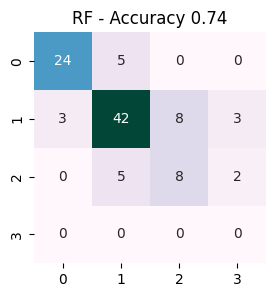

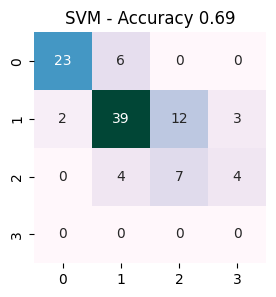

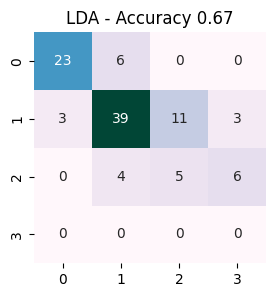

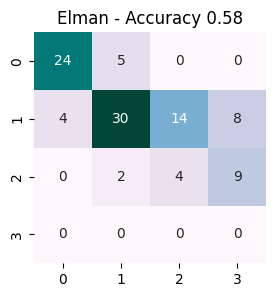

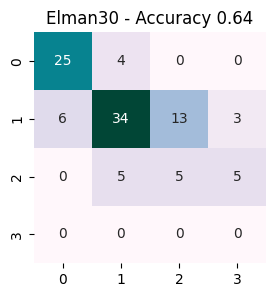

In [ ]:
models = ['RF', 'SVM', 'LDA', 'Elman', 'Elman30']
for t, p, m in zip(ds3_t[0], ds3_t[1], models):
  cm = confusion_matrix(t,p)
  fig, ax  = plt.subplots(figsize=(3,3))
  sns.heatmap(cm, annot=True, cbar=False, cmap='PuBuGn')

  acc = accuracy_score(t,p)
  ax.set_title(f'{m} - Accuracy {acc:.2f}')
  plt.savefig(f'/content/drive/MyDrive/images/{m}_ds3.png')
  plt.show()


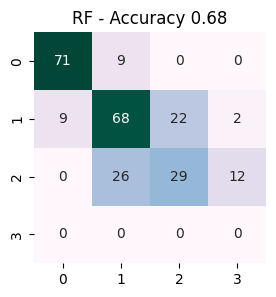

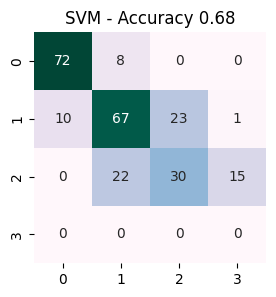

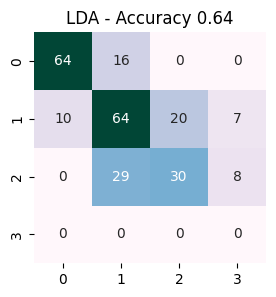

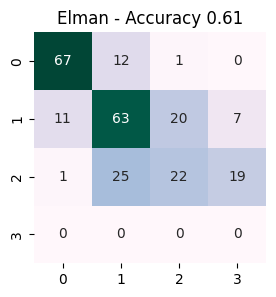

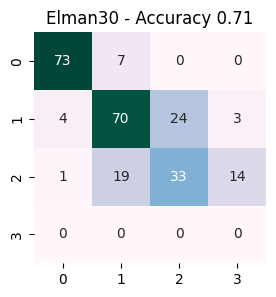

In [ ]:
models = ['RF', 'SVM', 'LDA', 'Elman', 'Elman30']
for t, p, m in zip(ds4_t[0], ds4_t[1], models):
  cm = confusion_matrix(t,p)
  fig, ax  = plt.subplots(figsize=(3,3))
  sns.heatmap(cm, annot=True, cbar=False, cmap='PuBuGn')
  acc = accuracy_score(t,p)
  ax.set_title(f'{m} - Accuracy {acc:.2f}')
  plt.savefig(f'/content/drive/MyDrive/images/{m}_ds4.png')
  plt.show()

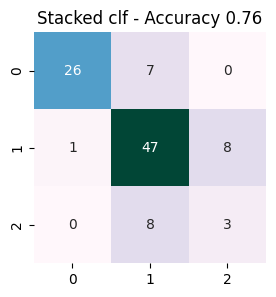

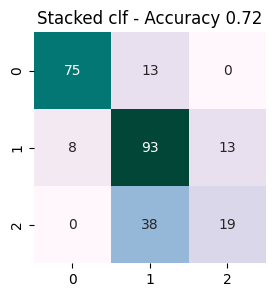

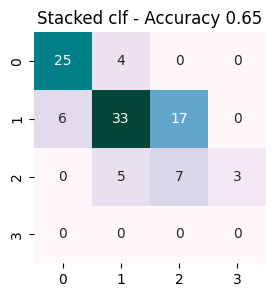

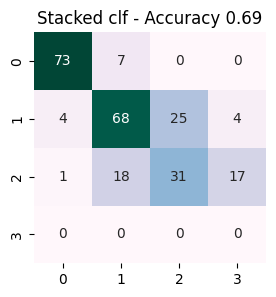

In [ ]:

for t, p in zip(stack_test, stack_pred):
  cm = confusion_matrix(t,p)
  fig, ax  = plt.subplots(figsize=(3,3))
  sns.heatmap(cm, annot=True, cbar=False, cmap='PuBuGn')
  acc = accuracy_score(t,p)
  ax.set_title(f'Stacked clf - Accuracy {acc:.2f}')


## F1 Scores

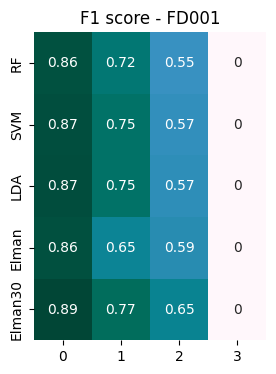

In [ ]:
models = ['RF', 'SVM', 'LDA', 'Elman1', 'Elman30']
ds1_scores = []
for model, t, p in zip(models, all_ds1[0], all_ds1[1]):
    f1 = precision_recall_fscore_support(t, p, zero_division=0)[2]
    ds1_scores.append(f1)

fig, ax  = plt.subplots(figsize=(3,4))
sns.heatmap(ds1_scores, cmap='PuBuGn',yticklabels=['RF', 'SVM', 'LDA', 'Elman', 'Elman30'], cbar = False, annot=True,fmt='.2g')
ax.set_title('F1 score - FD001')
plt.show()

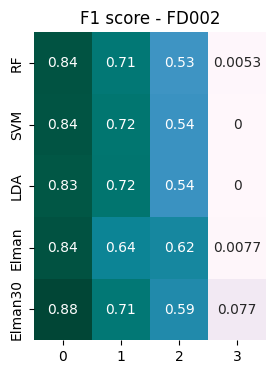

In [ ]:
ds2_scores = []
for model, t, p in zip(models, ds2[0], ds2[1]):
    f1 = precision_recall_fscore_support(t, p, zero_division=0)[2]
    ds2_scores.append(f1)

fig, ax  = plt.subplots(figsize=(3,4))
sns.heatmap(ds2_scores, cmap='PuBuGn',yticklabels=['RF', 'SVM', 'LDA', 'Elman', 'Elman30'], cbar = False, annot=True,fmt='.2g')
ax.set_title('F1 score - FD002')
plt.show()

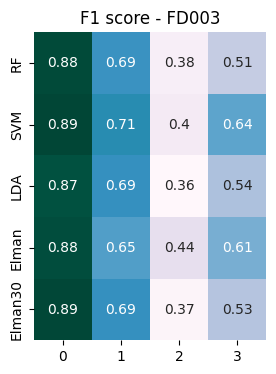

In [ ]:
ds3_scores = []
for model, t, p in zip(models, ds3[0], ds3[1]):
    f1 = precision_recall_fscore_support(t, p, zero_division=0)[2]
    ds3_scores.append(f1)

fig, ax  = plt.subplots(figsize=(3,4))
sns.heatmap(ds3_scores, cmap='PuBuGn',yticklabels=['RF', 'SVM', 'LDA', 'Elman', 'Elman30'], cbar = False, annot=True,fmt='.2g')
ax.set_title('F1 score - FD003')
plt.show()

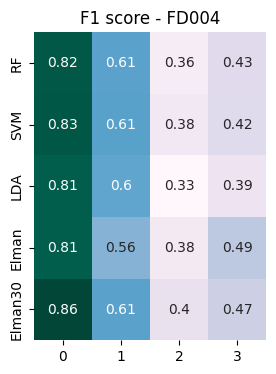

In [ ]:
ds4_scores = []
for model, t, p in zip(models, ds4[0], ds4[1]):
    f1 = precision_recall_fscore_support(t, p, zero_division=0)[2]
    ds4_scores.append(f1)

fig, ax  = plt.subplots(figsize=(3,4))
sns.heatmap(ds4_scores, cmap='PuBuGn',yticklabels=['RF', 'SVM', 'LDA', 'Elman', 'Elman30'], cbar = False, annot=True,fmt='.2g')
ax.set_title('F1 score - FD004')
plt.show()

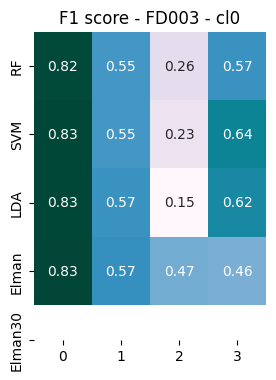

In [ ]:
dscl0_scores = []
for model, t, p in zip(models, dslc0[0], dslc0[1]):
    f1 = precision_recall_fscore_support(t, p, zero_division=0)[2]
    dscl0_scores.append(f1)

fig, ax  = plt.subplots(figsize=(3,4))
sns.heatmap(dscl0_scores, cmap='PuBuGn',yticklabels=['RF', 'SVM', 'LDA', 'Elman', 'Elman30'], cbar = False, annot=True,fmt='.2g')
ax.set_title('F1 score - FD003 - cl0')
plt.show()

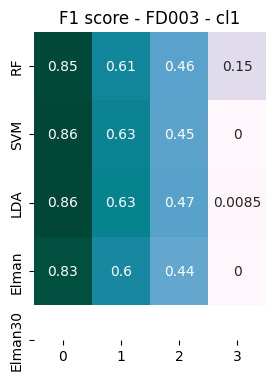

In [ ]:
dscl1_scores = []
for model, t, p in zip(models, dslc1[0], dslc1[1]):
    f1 = precision_recall_fscore_support(t, p, zero_division=0)[2]
    dscl1_scores.append(f1)

fig, ax  = plt.subplots(figsize=(3,4))
sns.heatmap(dscl1_scores, cmap='PuBuGn',yticklabels=['RF', 'SVM', 'LDA', 'Elman', 'Elman30'], cbar = False, annot=True,fmt='.2g')
ax.set_title('F1 score - FD003 - cl1')

plt.show()